# S–Li and <i>X</i>–Li RDF analysis
This notebook contains code for the calculation and plotting of S(4a/4c)–Li and <i>X</i>(4a/4c)–Li radial distribtion functions and coordination numbers, for Li<sub>6</sub>PS<sub>5</sub><i>X</i> (<i>X</i>=I, Cl) at 500 K.

In [1]:
from pymatgen import Structure, Lattice
from pymatgen.io.vasp import Xdatcar
from polyhedral_analysis.polyhedra_recipe import create_matching_site_generator
from vasppy.rdf import RadialDistributionFunction

import yaml
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, indices_by_species

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
verbose = True
x_spec='I'
coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure * [ 2, 2, 2 ]
## define a 2x2x2 cell of 4a sites
coords_4a = np.array( [ [ 0.0, 0.0, 0.0 ],
                        [ 0.5, 0.5, 0.0 ],
                        [ 0.0, 0.5, 0.5 ],
                        [ 0.5, 0.0, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure * [ 2, 2, 2 ]

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )


In [4]:
x_spec = { 'Li6PS5I': 'I',
           'Li6PS5Cl': 'Cl' }
data_dir = '../../data'

rdf_data = {}
for system in md_runs:
    rdf_data[system] = {}
    for disorder, runs in md_runs[system].items():
        rdf_data[system][disorder] = {}
        xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
        xdatcars = (Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list([x.structures for x in xdatcars])
        
        # Find indices of S/Cl atoms closest to 4c/4a crystallographic sites
        li_indices = indices_by_species( structures[0], 'Li' )
        s_indices = indices_by_species( structures[0], 'S' )
        x_indices = indices_by_species( structures[0], x_spec[system] )

        s_4c_indices = s_4c_matching_sites( structures[0], species='S' )
        s_4a_indices = s_4a_matching_sites( structures[0], species='S' )
        x_4c_indices = s_4c_matching_sites( structures[0], species=x_spec[system] )
        x_4a_indices = s_4a_matching_sites( structures[0], species=x_spec[system] )
        if s_4c_indices:
            print(f'{system} {disorder} S4c-Li')
            rdf_data[system][disorder]['S4c-Li'] = RadialDistributionFunction(structures, li_indices, 
                                                                           s_4c_indices, r_max=5.0)
        if s_4a_indices:
            print(f'{system} {disorder} S4a-Li')
            rdf_data[system][disorder]['S4a-Li'] = RadialDistributionFunction(structures, li_indices, 
                                                                           s_4a_indices, r_max=5.0)
        if x_4c_indices:
            print(f'{system} {disorder} {x_spec[system]}4c-Li')
            rdf_data[system][disorder]['X4c-Li'] = RadialDistributionFunction(structures, li_indices,
                                                                           x_4c_indices, r_max=5.0)
        if x_4a_indices:
            print(f'{system} {disorder} {x_spec[system]}4a-Li')
            rdf_data[system][disorder]['X4a-Li'] = RadialDistributionFunction(structures, li_indices,
                                                                           x_4a_indices, r_max=5.0)
inherent_rdf_data = rdf_data

rdf_data = {}
for system in md_runs:
    rdf_data[system] = {}
    for disorder, runs in md_runs[system].items():
        rdf_data[system][disorder] = {}
        xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/actual_XDATCAR.gz' for i in runs]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        
        # Find indices of S/Cl atoms closest to 4c/4a crystallographic sites
        li_indices = indices_by_species( structures[0], 'Li' )
        s_indices = indices_by_species( structures[0], 'S' )
        x_indices = indices_by_species( structures[0], x_spec[system] )

        s_4c_indices = s_4c_matching_sites( structures[0], species='S' )
        s_4a_indices = s_4a_matching_sites( structures[0], species='S' )
        x_4c_indices = s_4c_matching_sites( structures[0], species=x_spec[system] )
        x_4a_indices = s_4a_matching_sites( structures[0], species=x_spec[system] )
        if s_4c_indices:
            print(f'{system} {disorder} S4c-Li')
            rdf_data[system][disorder]['S4c-Li'] = RadialDistributionFunction(structures, li_indices, 
                                                                           s_4c_indices, r_max=5.0)
        if s_4a_indices:
            print(f'{system} {disorder} S4a-Li')
            rdf_data[system][disorder]['S4a-Li'] = RadialDistributionFunction(structures, li_indices, 
                                                                           s_4a_indices, r_max=5.0)
        if x_4c_indices:
            print(f'{system} {disorder} {x_spec[system]}4c-Li')
            rdf_data[system][disorder]['X4c-Li'] = RadialDistributionFunction(structures, li_indices,
                                                                           x_4c_indices, r_max=5.0)
        if x_4a_indices:
            print(f'{system} {disorder} {x_spec[system]}4a-Li')
            rdf_data[system][disorder]['X4a-Li'] = RadialDistributionFunction(structures, li_indices,
                                                                           x_4a_indices, r_max=5.0)
actual_rdf_data = rdf_data

Li6PS5I 0p S4c-Li
Li6PS5I 0p I4a-Li
Li6PS5I 50p S4c-Li
Li6PS5I 50p S4a-Li
Li6PS5I 50p I4c-Li
Li6PS5I 50p I4a-Li
Li6PS5I 100p S4a-Li
Li6PS5I 100p I4c-Li
Li6PS5Cl 0p S4c-Li
Li6PS5Cl 0p Cl4a-Li
Li6PS5Cl 50p S4c-Li
Li6PS5Cl 50p S4a-Li
Li6PS5Cl 50p Cl4c-Li
Li6PS5Cl 50p Cl4a-Li
Li6PS5Cl 100p S4a-Li
Li6PS5Cl 100p Cl4c-Li
Li6PS5I 0p S4c-Li
Li6PS5I 0p I4a-Li
Li6PS5I 50p S4c-Li
Li6PS5I 50p S4a-Li
Li6PS5I 50p I4c-Li
Li6PS5I 50p I4a-Li
Li6PS5I 100p S4a-Li
Li6PS5I 100p I4c-Li
Li6PS5Cl 0p S4c-Li
Li6PS5Cl 0p Cl4a-Li
Li6PS5Cl 50p S4c-Li
Li6PS5Cl 50p S4a-Li
Li6PS5Cl 50p Cl4c-Li
Li6PS5Cl 50p Cl4a-Li
Li6PS5Cl 100p S4a-Li
Li6PS5Cl 100p Cl4c-Li


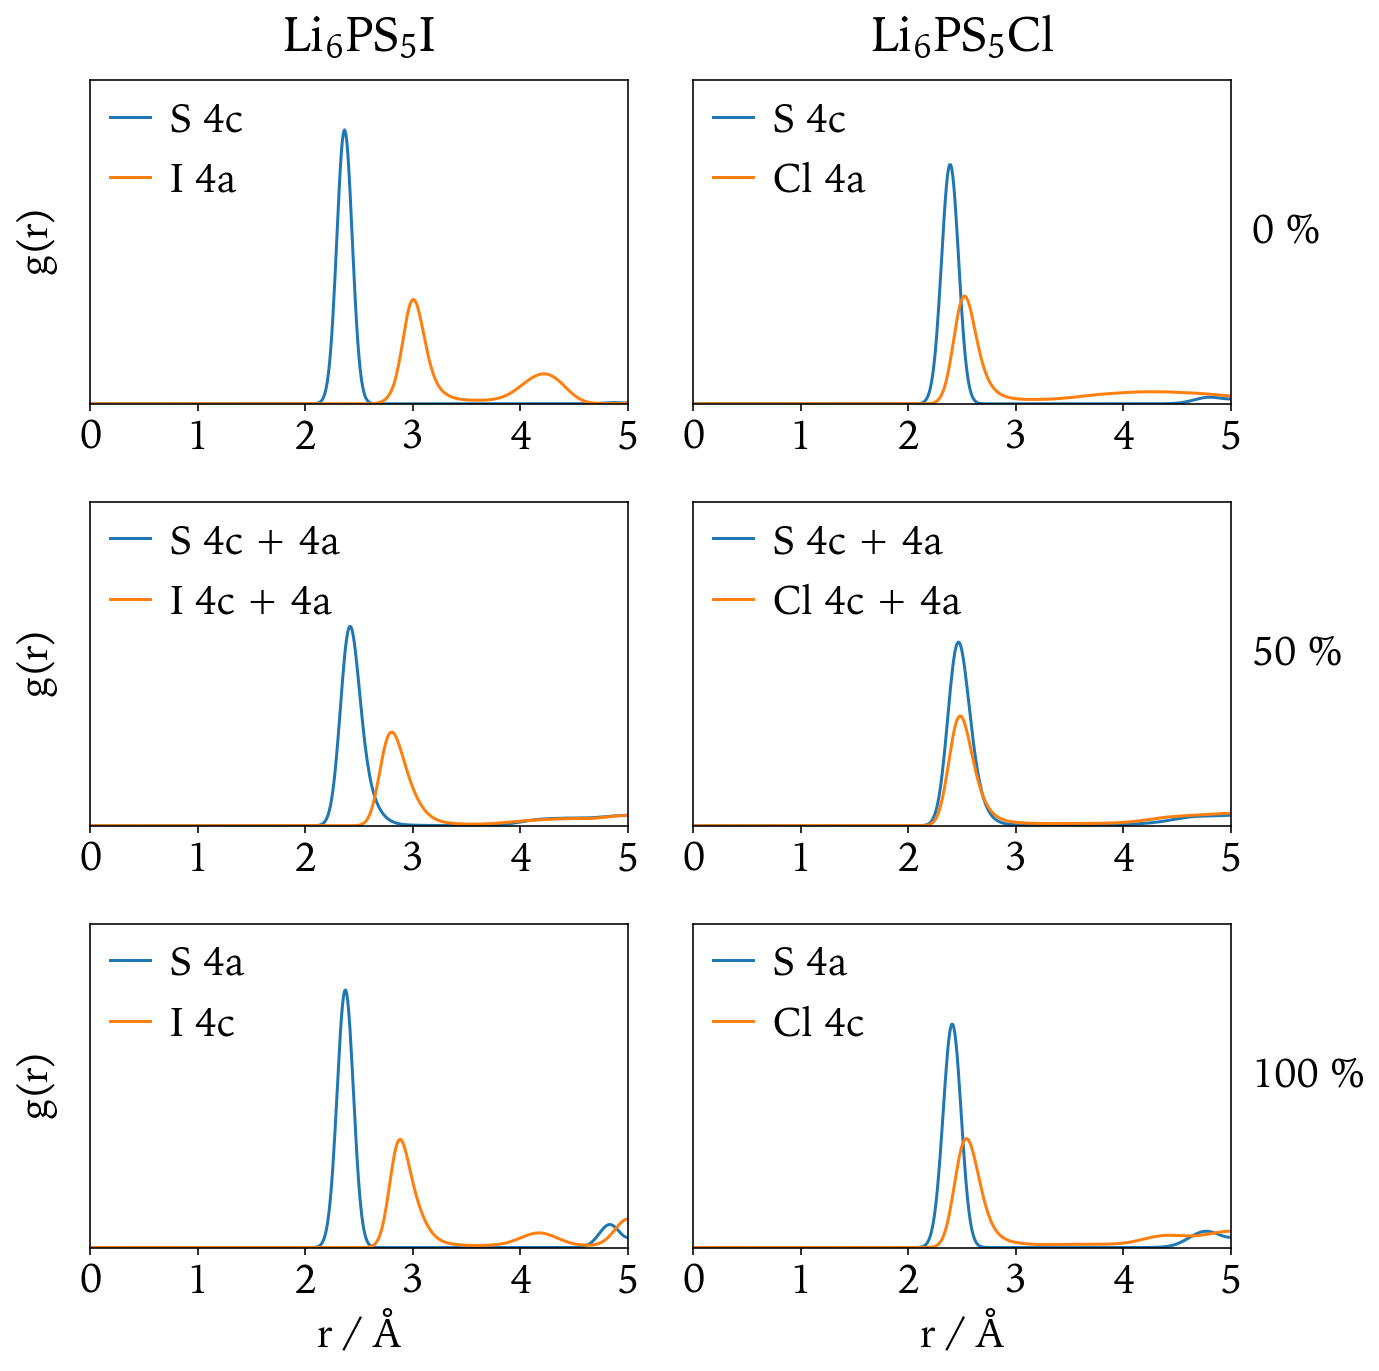

In [6]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 20})

def plot_rdf(rdf, axes, sigma, label=None):
    axes.plot(rdf.r, rdf.smeared_rdf(sigma=sigma), label=label)
    
def plot_summed_rdfs(rdfs, axes, sigma, label=None):
    axes.plot(rdfs[0].r, np.mean( [ rdf.smeared_rdf(sigma=sigma) for rdf in rdfs ], axis=0 ), label=label )
              
sigma = 0.07
fig, ax = plt.subplots(3,2,figsize=(10,10))

plot_rdf(inherent_rdf_data['Li6PS5I']['0p']['S4c-Li'], axes=ax[0,0], sigma=sigma, label='S 4c')
plot_rdf(inherent_rdf_data['Li6PS5I']['0p']['X4a-Li'], axes=ax[0,0], sigma=sigma, label='I 4a')

plot_summed_rdfs([inherent_rdf_data['Li6PS5I']['50p']['S4c-Li'],
                  inherent_rdf_data['Li6PS5I']['50p']['S4a-Li']], axes=ax[1,0], sigma=sigma, label='S 4c + 4a')
plot_summed_rdfs([inherent_rdf_data['Li6PS5I']['50p']['X4c-Li'],
                  inherent_rdf_data['Li6PS5I']['50p']['X4a-Li']], axes=ax[1,0], sigma=sigma, label='I 4c + 4a')

plot_rdf(inherent_rdf_data['Li6PS5I']['100p']['S4a-Li'], axes=ax[2,0], sigma=sigma, label='S 4a')
plot_rdf(inherent_rdf_data['Li6PS5I']['100p']['X4c-Li'], axes=ax[2,0], sigma=sigma, label='I 4c')

plot_rdf(inherent_rdf_data['Li6PS5Cl']['0p']['S4c-Li'], axes=ax[0,1], sigma=sigma, label='S 4c')
plot_rdf(inherent_rdf_data['Li6PS5Cl']['0p']['X4a-Li'], axes=ax[0,1], sigma=sigma, label='Cl 4a')


plot_summed_rdfs([inherent_rdf_data['Li6PS5Cl']['50p']['S4c-Li'],
                  inherent_rdf_data['Li6PS5Cl']['50p']['S4a-Li']], axes=ax[1,1], sigma=sigma, label='S 4c + 4a')
plot_summed_rdfs([inherent_rdf_data['Li6PS5Cl']['50p']['X4c-Li'],
                  inherent_rdf_data['Li6PS5Cl']['50p']['X4a-Li']], axes=ax[1,1], sigma=sigma, label='Cl 4c + 4a')

plot_rdf(inherent_rdf_data['Li6PS5Cl']['100p']['S4a-Li'], axes=ax[2,1], sigma=sigma, label='S 4a')
plot_rdf(inherent_rdf_data['Li6PS5Cl']['100p']['X4c-Li'], axes=ax[2,1], sigma=sigma, label='Cl 4c')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0,25])
        ax[i,j].set_xlim([0,5])
        ax[i,j].set_yticks([])
        ax[i,j].legend(loc='upper left', frameon=False, borderpad=0.0, handlelength=1.0, handletextpad=0.5)
        
for i in range(3):
        ax[i,1].get_yaxis().set_visible(False)
        for j in range(2):
            ax[i,j].set_xticks(range(6))

xlabel = r'$r$ / $\mathrm{\AA}$'
ylabel = r'$g(r)$'
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)
ax[0,0].set_ylabel(ylabel, labelpad=15)
ax[1,0].set_ylabel(ylabel, labelpad=15)
ax[2,0].set_ylabel(ylabel, labelpad=15)

ax[0,1].text(5.2,12.5,'0 %')
ax[1,1].text(5.2,12.5,'50 %')
ax[2,1].text(5.2,12.5,'100 %')
    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/X-Li-rdf.pdf')
fig.show()

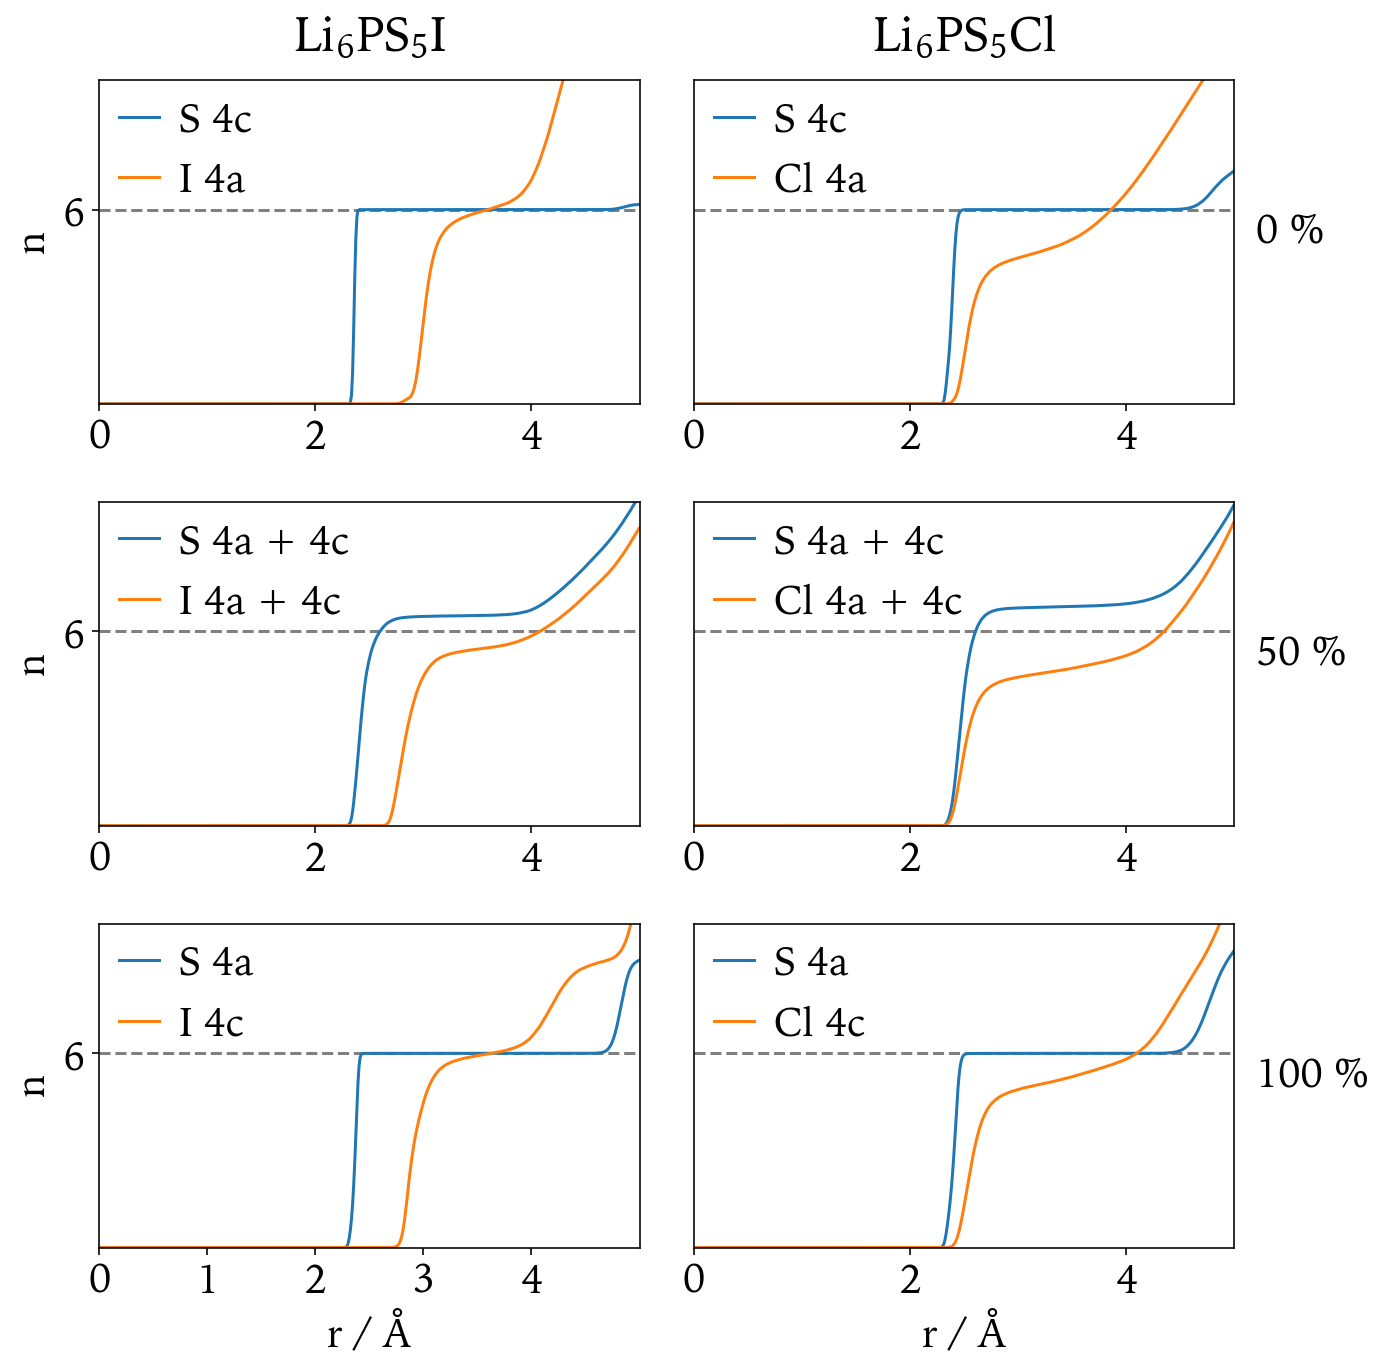

In [7]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 20})


def plot_cn(rdf, axes, sigma, label=None):
    axes.plot(rdf.r, rdf.coordination_number, label=label)
    
def plot_summed_cns(rdfs, axes, sigma, label=None):
    axes.plot(rdfs[0].r, np.mean( [ rdf.coordination_number for rdf in rdfs ], axis=0 ), label=label )
              
sigma = 0.07
fig, ax = plt.subplots(3,2,figsize=(10,10))

plot_cn(inherent_rdf_data['Li6PS5I']['0p']['S4c-Li'], axes=ax[0,0], sigma=sigma, label='S 4c')
plot_cn(inherent_rdf_data['Li6PS5I']['0p']['X4a-Li'], axes=ax[0,0], sigma=sigma, label='I 4a')

plot_summed_cns([inherent_rdf_data['Li6PS5I']['50p']['S4c-Li'],
                  inherent_rdf_data['Li6PS5I']['50p']['S4a-Li']], axes=ax[1,0], sigma=sigma, label='S 4a + 4c')
plot_summed_cns([inherent_rdf_data['Li6PS5I']['50p']['X4c-Li'],
                  inherent_rdf_data['Li6PS5I']['50p']['X4a-Li']], axes=ax[1,0], sigma=sigma, label='I 4a + 4c')

plot_cn(inherent_rdf_data['Li6PS5I']['100p']['S4a-Li'], axes=ax[2,0], sigma=sigma, label='S 4a')
plot_cn(inherent_rdf_data['Li6PS5I']['100p']['X4c-Li'], axes=ax[2,0], sigma=sigma, label='I 4c')

plot_cn(inherent_rdf_data['Li6PS5Cl']['0p']['S4c-Li'], axes=ax[0,1], sigma=sigma, label='S 4c')
plot_cn(inherent_rdf_data['Li6PS5Cl']['0p']['X4a-Li'], axes=ax[0,1], sigma=sigma, label='Cl 4a')


plot_summed_cns([inherent_rdf_data['Li6PS5Cl']['50p']['S4c-Li'],
                  inherent_rdf_data['Li6PS5Cl']['50p']['S4a-Li']], axes=ax[1,1], sigma=sigma, label='S 4a + 4c')
plot_summed_cns([inherent_rdf_data['Li6PS5Cl']['50p']['X4c-Li'],
                  inherent_rdf_data['Li6PS5Cl']['50p']['X4a-Li']], axes=ax[1,1], sigma=sigma, label='Cl 4a + 4c')

plot_cn(inherent_rdf_data['Li6PS5Cl']['100p']['S4a-Li'], axes=ax[2,1], sigma=sigma, label='S 4a')
plot_cn(inherent_rdf_data['Li6PS5Cl']['100p']['X4c-Li'], axes=ax[2,1], sigma=sigma, label='Cl 4c')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0,10])
        ax[i,j].set_xlim([0,5])
        ax[i,j].hlines(6.0, 0.0, 5.0, linestyle='--', color='grey')
        ax[i,j].set_yticks([6.0])
        ax[i,j].legend(loc='upper left', frameon=False, borderpad=0.0, handlelength=1.0, handletextpad=0.5)
        
# for i in range(2):
#     for j in range(2):
#         ax[i,j].get_xaxis().set_visible(False)
        
for i in range(3):
        ax[i,1].get_yaxis().set_visible(False)

xlabel = r'$r$ / $\mathrm{\AA}$'
ylabel = r'$n$'
ax[2,0].set_xticks(range(5))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(5.2,5.0,'0 %')
ax[1,1].text(5.2,5.0,'50 %')
ax[2,1].text(5.2,5.0,'100 %')
    
fig.tight_layout()
# fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('../../figures/X-Li-coordination_numbers.pdf')
fig.show()

In [8]:
%load_ext version_information

%version_information yaml, matplotlib, numpy, pymatgen, polyhedral_analysis, vasppy

Software versions
Python 3.7.0 64bit [Clang 10.0.0 (clang-1000.10.44.2)]
IPython 7.0.1
OS Darwin 19.4.0 x86_64 i386 64bit
yaml 5.2
matplotlib 3.2.0rc1
numpy 1.18.3
pymatgen 2020.1.28
polyhedral_analysis 0.1
vasppy 0.6.1.0
Sun May 24 07:45:20 2020 BST